# Working with NIfTI images

[NIfTI](https://nifti.nimh.nih.gov/) stands for *Neuroimaging Informatics Technology Initiative*, which is jointly sponsored by the US  National Institute of Mental Health and the National Institute of Neurological Disorders and Stroke. NIfTI defines a file format for neuroimaging data that is meant to meet the needs of the fMRI research community. In particular, NIfTI was developed to support inter-operability of tools and software through a common file format. Prior to NIfTI there were a few major fMRI analysis software packages, and each used a different file format. NIfTI was designed to serve as a common file format for all of these (and future) neuroimaging software packages.



Although other file formats are still used by some software, NIfTI has become the most widely used standard for fMRI and other MRI research data file storage. Here we will learn how to convert a DICOM file to NIfTI format, which is typically the first step in an MRI research analysis pipeline, since most MRI scanners produce DICOM files, but the software researchers use to process their data reads NIFTI and not DICOM format.

## Import packages

Here we load in three new Python packages designed to work with NIfTI data:
- `dicom2nifti` converst DICOM images to NIfTI format
- `NiBabel` reads and converts between NIfTI and several other common neuroimaging file formats, including ANALYZE
- `NiLearn` is primarily designed to provide statistical analysis and machine learning tools for neuroimaging data. However, it also provides a number of utilities for reading and writing NIfTI images, and working with and visualizing data

As well we'll load SciPy's ndimage package, and Matplotlib

In [9]:
!pip install nilearn
!pip install dicom2nifti

import dicom2nifti
import nibabel as nib
import nilearn as nil
import scipy.ndimage as ndi
import matplotlib.pyplot as plt
import os
%matplotlib inline

We will use `dicom2nifti`'s `convert_directory()` function to convert the structural MRI images we worked with in the previous lesson from DICOM to NIfTI. We pass it the name of the folder in which the DICOM images are saved, and also instruct it to compress the resulting NIfTI file (to save space). We also use the `reorient=True` kwarg to force the image to be written in LAI orientation (i.e., starting with the most left, anterior, and inferior voxel), which ensures there is no ambiguity about the resulting NIfTI image.

`convert_directory` does not take an argument for the output file name. Instead, it uses the name of the scan that was used when it was acquired on the MRI scanner. This might seem like a frustrating lack of control, however it does ensure that there are no user errors in the conversion process, that could result in mis-identified files. Here we will first list the contents of the `data` folder, then run `convert_directory`, then list the contents again to see the new NIfTI file and what it is named:

In [27]:
os.listdir('./')

%cd sample_data
!pwd

/content/sample_data
/content/sample_data


## Load NIfTI file

We use `NiBabel` to read in the NIfTI file we just created:

In [31]:
import requests

def get_nifti_file_from_url(my_url, filename):
  response = requests.get(my_url)
  if response.status_code == 200:
     with open(filename, 'wb') as f:
         f.write(response.content)
         return nib.load(filename)
  else:
      print("Failed to download the image. Check the URL and try again.")


cardiac_vol_4d = get_nifti_file_from_url('https://humanheart-project.creatis.insa-lyon.fr/database/api/v1/file/6372204873e9f0047faa1615/download', 'patient001_4d.nii.gz')
cardiac_vol1 = get_nifti_file_from_url('https://humanheart-project.creatis.insa-lyon.fr/database/api/v1/file/6372204873e9f0047faa1619/download', 'patient001_frame01.nii.gz')
cardiac_vol2 = get_nifti_file_from_url('https://humanheart-project.creatis.insa-lyon.fr/database/api/v1/file/6372204873e9f0047faa1611/download', 'patient001_frame01_gt.nii.gz')
cardiac_vol3 = get_nifti_file_from_url('https://humanheart-project.creatis.insa-lyon.fr/database/api/v1/file/6372204873e9f0047faa161d/download', 'patient001_frame12.nii.gz')
cardiac_vol4 = get_nifti_file_from_url('https://humanheart-project.creatis.insa-lyon.fr/database/api/v1/file/6372204873e9f0047faa1621/download', 'patient001_frame12_gt.nii.gz')

# What is the type of this object?
type(cardiac_vol_4d)

nibabel.nifti1.Nifti1Image

## View metadata

We can view the image's header by printing it (note that due to how the NiBabel `Nifti1Image` object is coded, we need to `print()` the header rather than just asking for it as a property):

In [32]:
print(cardiac_vol_4d.header)

<class 'nibabel.nifti1.Nifti1Header'> object, endian='<'
sizeof_hdr      : 348
data_type       : b''
db_name         : b''
extents         : 0
session_error   : 0
regular         : b''
dim_info        : 0
dim             : [  4 232 256  10  30   1   1   1]
intent_p1       : 0.0
intent_p2       : 0.0
intent_p3       : 0.0
intent_code     : none
datatype        : float32
bitpix          : 32
slice_start     : 0
pixdim          : [ 1.       1.64062  1.64062 10.       1.       1.       1.       1.     ]
vox_offset      : 0.0
scl_slope       : nan
scl_inter       : nan
slice_end       : 0
slice_code      : unknown
xyzt_units      : 0
cal_max         : 0.0
cal_min         : 0.0
slice_duration  : 0.0
toffset         : 0.0
glmax           : 0
glmin           : 0
descrip         : b''
aux_file        : b''
qform_code      : unknown
sform_code      : aligned
quatern_b       : 0.0
quatern_c       : 0.0
quatern_d       : 1.0
qoffset_x       : -0.0
qoffset_y       : -0.0
qoffset_z       : 0.0
srow_

## Access data in the NIfTI object

NiBabel's handling of the NIfTI format data is not quite as elegant as what we saw in teh previous lesson. Rather than being able to access the data directly by referencing the name of the object (in this case, `cardiac_vol1`), we need to use the method `get_fdata()` to do this (the "f" in this method name stands for "floating point", as this is the type of data it returns). We will assign the result of this to a new variable so that it's easy to work with.

In [33]:
cardiac_vol_data = cardiac_vol1.get_fdata()
type(cardiac_vol_data)


numpy.ndarray

We see that the data is a familiar NumPy array, and below we see the dimensions are identical to what we saw for this image in the previous lesson:

In [34]:
print(cardiac_vol_4d.shape)
print(cardiac_vol1.shape)
print(cardiac_vol2.shape )
print(cardiac_vol3.shape )
print(cardiac_vol4.shape)

(232, 256, 10, 30)
(232, 256, 10)
(232, 256, 10)
(232, 256, 10)
(232, 256, 10)


In [35]:
cardiac_vol_data

array([[[19., 20., 18., ..., 16., 15., 14.],
        [19., 20., 18., ..., 16., 15., 14.],
        [19., 20., 18., ..., 16., 15., 14.],
        ...,
        [19., 20., 18., ..., 16., 15., 14.],
        [19., 20., 18., ..., 16., 15., 14.],
        [19., 20., 18., ..., 16., 15., 14.]],

       [[19., 20., 18., ..., 16., 15., 14.],
        [19., 20., 18., ..., 16., 15., 14.],
        [26., 30., 18., ..., 16., 15., 14.],
        ...,
        [19., 20., 18., ..., 16., 15., 14.],
        [19., 20., 18., ..., 16., 15., 14.],
        [19., 20., 18., ..., 16., 15., 14.]],

       [[19., 20., 18., ..., 16., 15., 14.],
        [19., 20., 18., ..., 16., 15., 14.],
        [26., 29., 18., ..., 16., 15., 14.],
        ...,
        [19., 20., 18., ..., 16., 15., 14.],
        [19., 20., 18., ..., 16., 15., 14.],
        [19., 20., 18., ..., 16., 15., 14.]],

       ...,

       [[19., 20., 18., ..., 16., 15., 14.],
        [19., 20., 18., ..., 16., 15., 14.],
        [19., 20., 18., ..., 16., 15., 14.

## Visualize a slice

We can use `.plt.imshow()` as in the previous lesson:

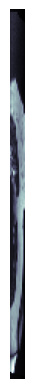

In [36]:
plt.imshow(cardiac_vol_data[60], cmap='bone')
plt.axis('off')
plt.show()

Note that our image is rotated, so use can use `ndi.rotate` to fix this:

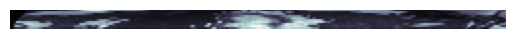

In [37]:
plt.imshow(ndi.rotate(cardiac_vol_data[96], 90), cmap='bone')
plt.axis('off')
plt.show()

## Plot a series of slices

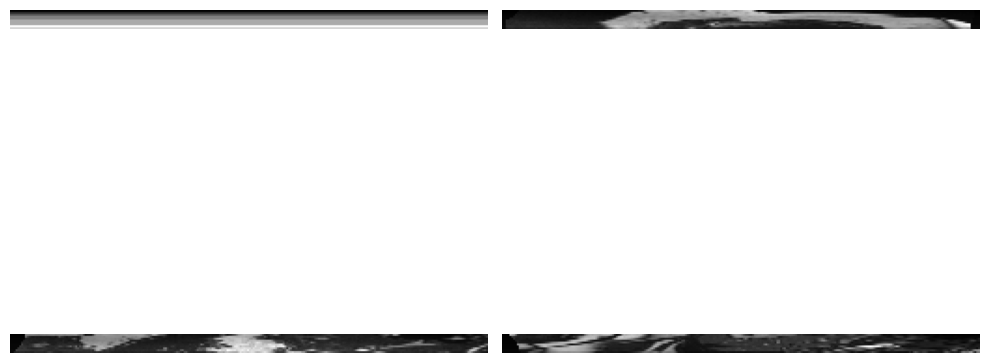

In [38]:
fig_rows = 2

fig_cols = 2
n_subplots = fig_rows * fig_cols
n_slice = cardiac_vol_data.shape[0]
step_size = n_slice // n_subplots
plot_range = n_subplots * step_size
start_stop = int((n_slice - plot_range) / 2)

fig, axs = plt.subplots(fig_rows, fig_cols, figsize=[10, 10])

for idx, img in enumerate(range(start_stop, plot_range, step_size)):
    axs.flat[idx].imshow(ndi.rotate(cardiac_vol_data[img, :, :], 90), cmap='gray')
    axs.flat[idx].axis('off')

plt.tight_layout()
plt.show()

## Plot with NiLearn

While SciPy's ndimage module was designed for working with a wide variety of image types, NiLearn was designed to work with neuroimaging data specifically. As such, it's tools are a bit easier to use and more purpose-built for tasks that neuroimaging data scientists might want to perform. For example, we can plot the NiBabel NIfTI image object directly without first having to extract the data, using the `plot_img()` function from NiLearn's `plotting` module:

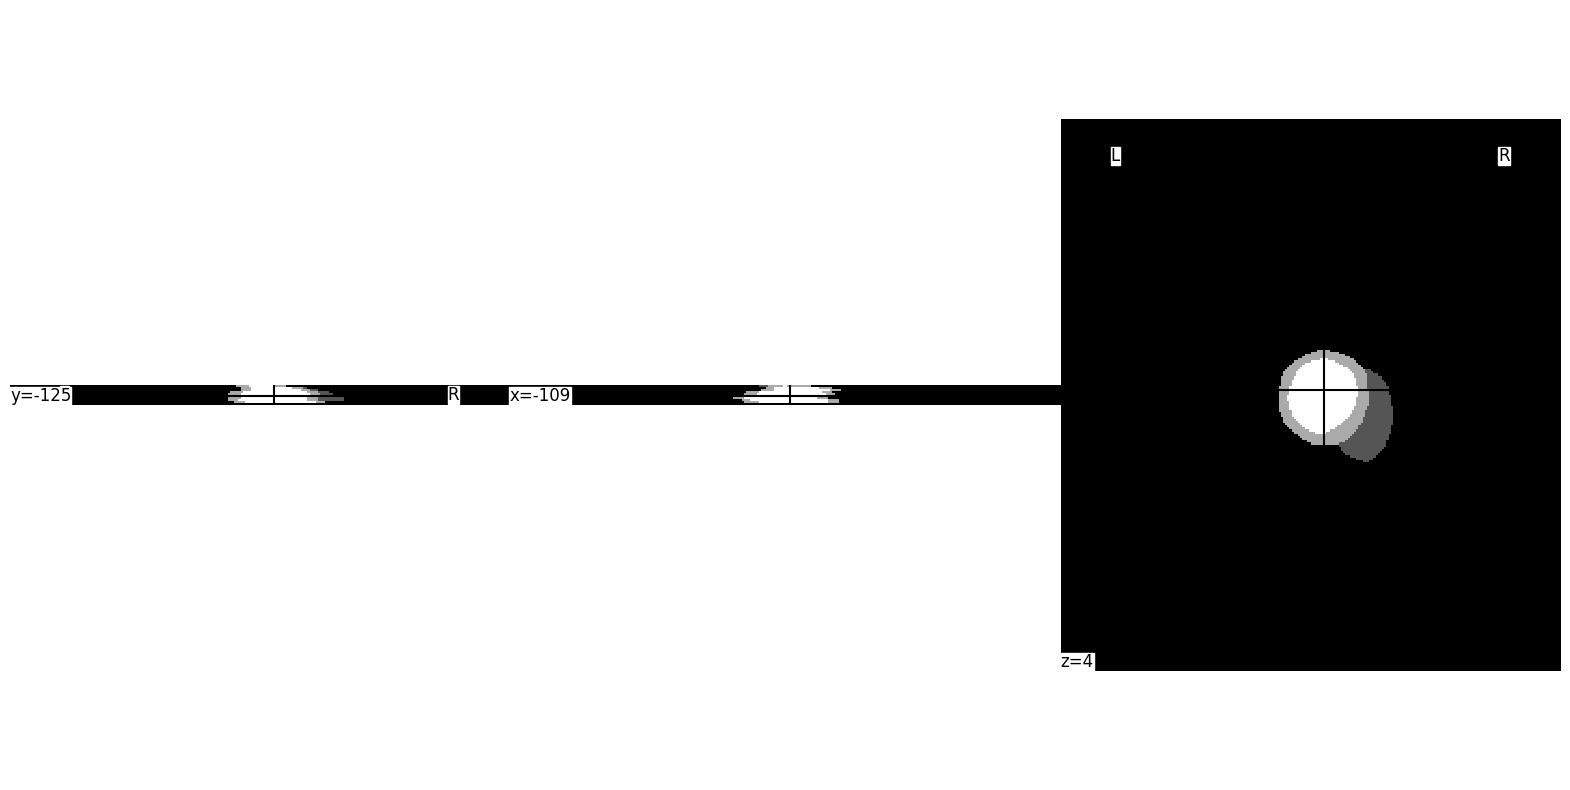

In [39]:
from nilearn import plotting
fig,ax=plt.subplots(figsize=[20, 10])
plotting.plot_img(cardiac_vol4, cmap="gray",axes=ax)
plt.show()

One nice thing that we see is that since NiLearn is neuroimaging-aware, it explicitly adds labels to our plot showing us clearly which the left and right hemispheres are.

NiLearn's plotting library uses Matplotlib, so we can use familiar tricks to do things like adjust the image size and colourmap:

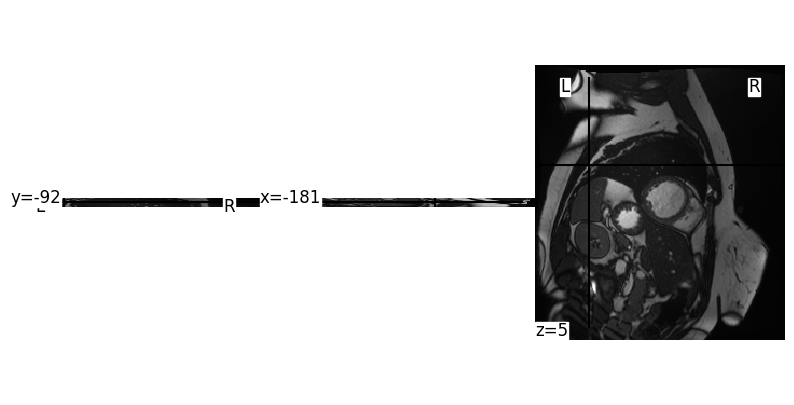

In [42]:
from nilearn import plotting

fig, ax = plt.subplots(figsize=[10, 5])
plotting.plot_img(cardiac_vol1, cmap='gray', axes=ax)
plt.show()

The `plot_img()` function also provides a variety of ways to display the hearth, with much less code than we had to use when working with raw NumPy arrays and Matplotlib functions:

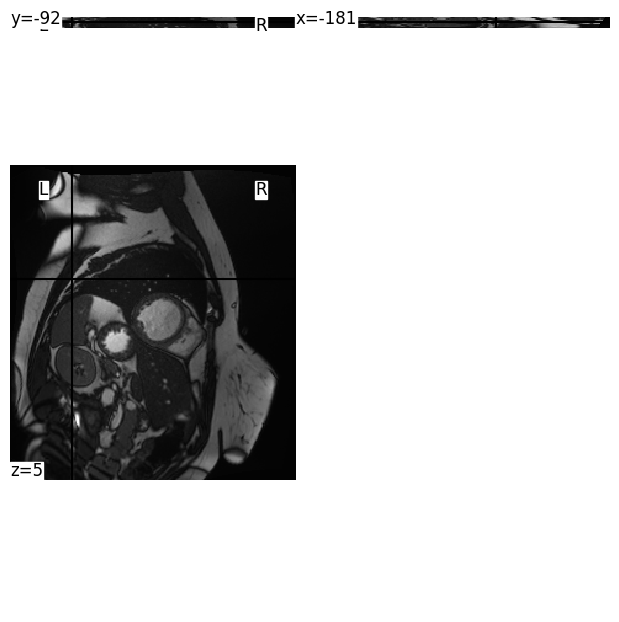

In [43]:
plotting.plot_img(cardiac_vol1, display_mode='tiled', cmap='gray')
plt.show()

We can use the `cut_coords` kwarg to specify there to centre the crosshairs and "cuts" through the image that we visualize. In this image, the coordinates are relative to the *isocentre* of the MRI scanner — the centre of the magnetic field inside the scanner. The position of a person's head relative to this isocentre will vary from individual to individual, and scan to scan, due to variations in head size and the optimizations used by the MRI technician and scanner. But we can use the coorindates printed in teh above image (which defaulted to the centre of the image volume) and some trial-and-error to get a different view through the chest:

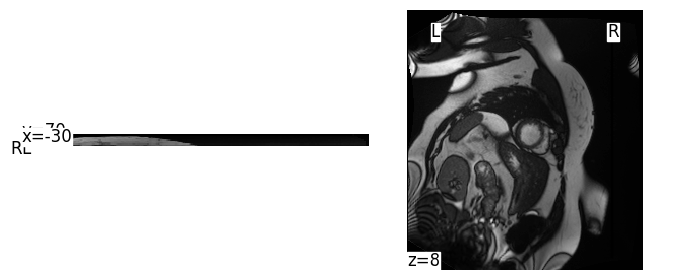

In [44]:
plotting.plot_img(cardiac_vol1, cmap='gray', cut_coords=(-30, 70, 8))
plt.show()

`plot_img()` also has a few other ways to see multiple slices at once:

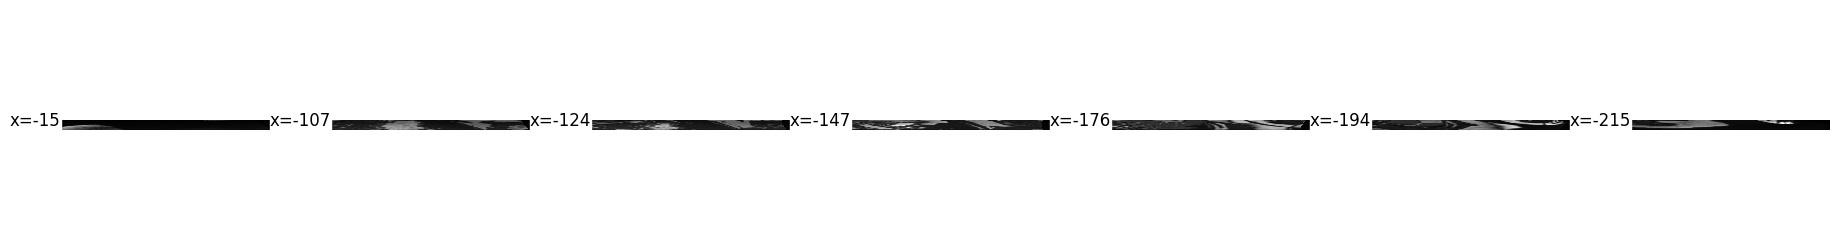

In [45]:
plotting.plot_img(cardiac_vol1, display_mode='x', cmap='gray')
plt.show()

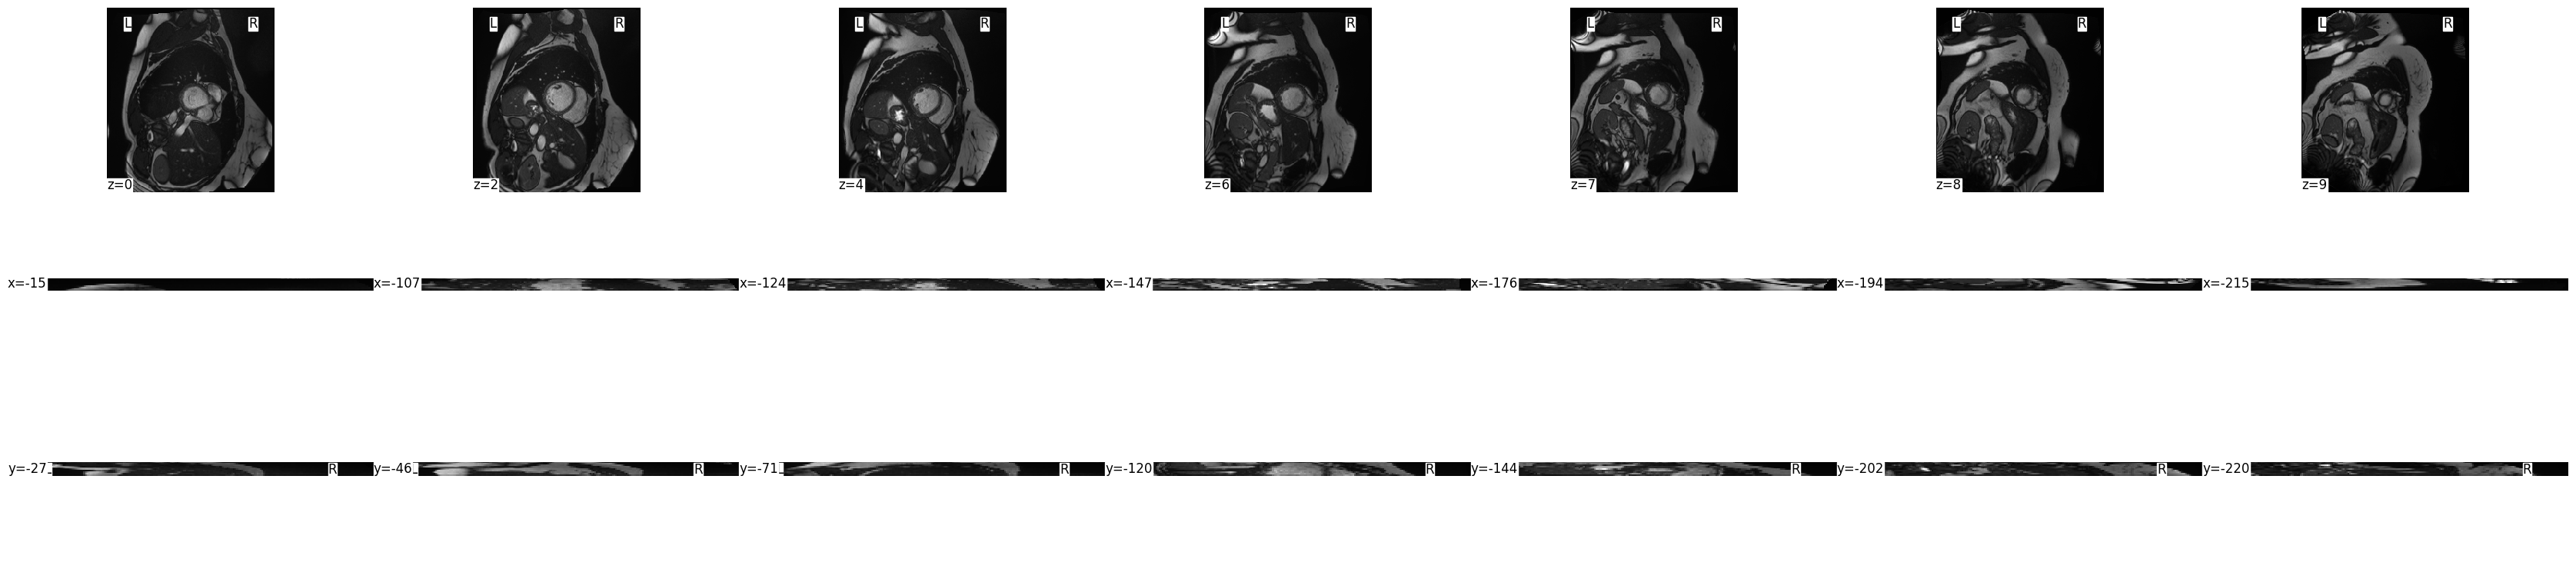

In [46]:
plotting.plot_img(cardiac_vol1, display_mode='mosaic', cmap='gray')
plt.show()

## Smoothing

NiLearn has its own function for applying Gaussian spatial smoothing to images as well. The only real difference from scipy.ndimage's `gaussian_filter()` function is that instead of specifying the smoothing kernel in standard deviations, we specify it in units of **full width half-maximum (FWHM)**. This is the standard way that most neuroimaging analysis packages specify smoothing kernel size, so it is preferable to SciPy's approach. As the term implies, FWHM is the width of the smoothing kernel, in millimetres, at the point in the kernel where it is half of its maximum height. Thus a larger FWHM value applies more smoothing.

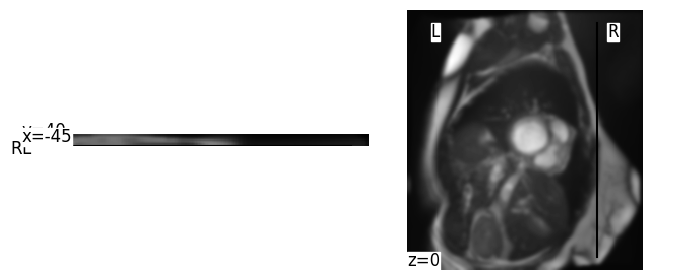

In [47]:
from nilearn import image

fwhm = 4

cardiac_vol_smth = image.smooth_img(cardiac_vol1, fwhm)
plotting.plot_img(cardiac_vol_smth, cmap='gray', cut_coords=(-45, 40, 0))
plt.show()